# **Data Loading and Cleaning**

In [2]:
CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'pakistan-traffic-accident-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1405690%2F2328706%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240719%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240719T175652Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D3c6d9caf3c4e1215c5cf4a2c940edb2573a85b4774508d847f88505d8726435b73a4658eb85f66c4b57be73a3c0b67aca294c91edf5956c08621a05a7ffe97fe23468628cfa1a31e10a76be5739af75e00f0484ac01f12fd0dc8fc86d6da2ee5d0888c230980c2e06152f7bbbcf744abe9fafd66759e1d15e4b03ecaf2f40fe84d5d6091d30c9e10c0c64c62dc975384694742f6aeee730cabedcb82de88184a8f310f04b97bc35e2c8a6222bd421c33f3f72324a755a4086b952fd50341bdd8d098dddc6e5d05b453098f1ee10b1b44e68a4b41cc9fd360088af41bd7cbe0dd7ea4f3d9984eaef6d79d1a4b14ab3b372a2ff6fbd513acaf4741ea07e2418a32'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')

[==================================================] 1502 bytes downloaded
Downloaded and uncompressed: pakistan-traffic-accident-dataset
Data source import complete.


In [1]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import plotly.express as px

In [3]:
# Load and clean data
df = pd.read_csv('/kaggle/input/pakistan-traffic-accident-dataset/traffic-accidents-annual-.csv')
df = df[1:]
df.columns = ["City", "Year", "Total number of accidents", "Fatal Accidents", "Non-Fatal Accidents",
            "Killed", "Injured", "Total number of vehicles involved"]

In [4]:
np.random.seed(0)
df['Road_Conditions'] = np.random.choice(['Dry', 'Wet', 'Snowy', 'Icy'], size=len(df))
df['Weather'] = np.random.choice(['Clear', 'Rain', 'Snow', 'Fog'], size=len(df))
df['Time_of_Day'] = np.random.choice(['Morning', 'Afternoon', 'Evening', 'Night'], size=len(df))

In [5]:
# Convert columns to numeric types
df["Year"] = df["Year"].astype(str).str[:4].astype(int)
df["Total number of accidents"] = pd.to_numeric(df["Total number of accidents"])
df["Fatal Accidents"] = pd.to_numeric(df["Fatal Accidents"])
df["Non-Fatal Accidents"] = pd.to_numeric(df["Non-Fatal Accidents"])
df["Killed"] = pd.to_numeric(df["Killed"])
df["Injured"] = pd.to_numeric(df["Injured"])
df["Total number of vehicles involved"] = pd.to_numeric(df["Total number of vehicles involved"])

In [6]:
# Calculate fatal rate
df["Fatal rate"] = df["Fatal Accidents"] / df["Total number of accidents"]

# **Exploratory Data Analysis**

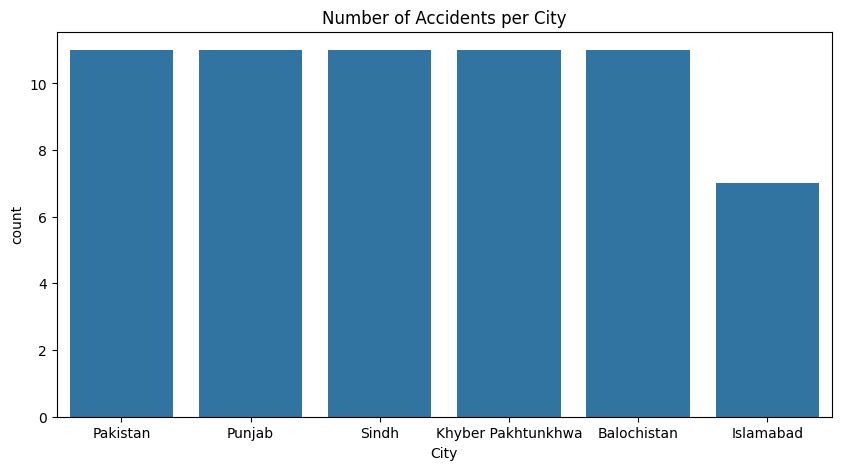

In [7]:
# Exploratory Data Analysis
plt.figure(figsize=(10,5))
sns.countplot(data=df, x="City")
plt.title('Number of Accidents per City')
plt.show()

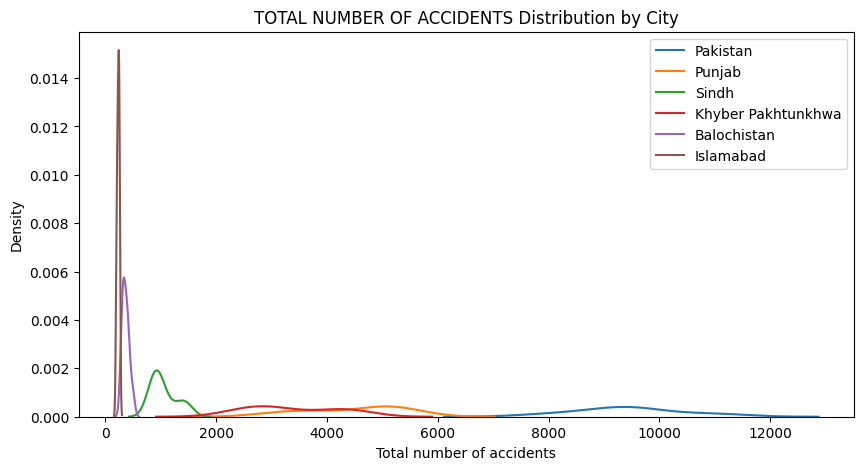

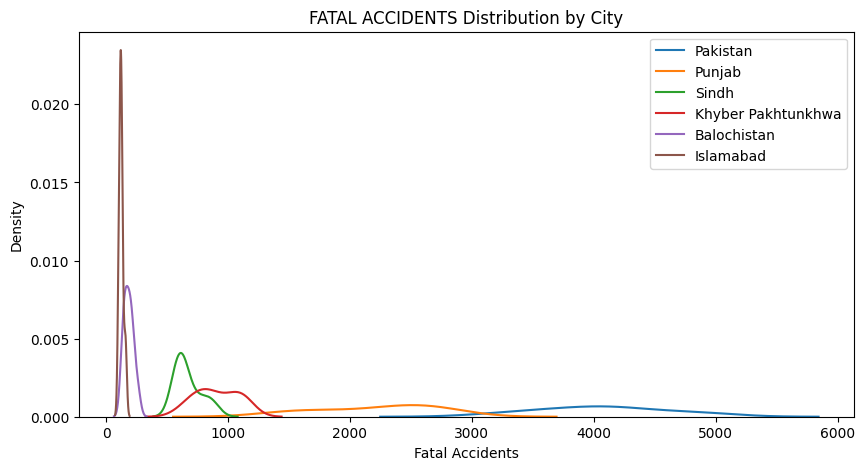

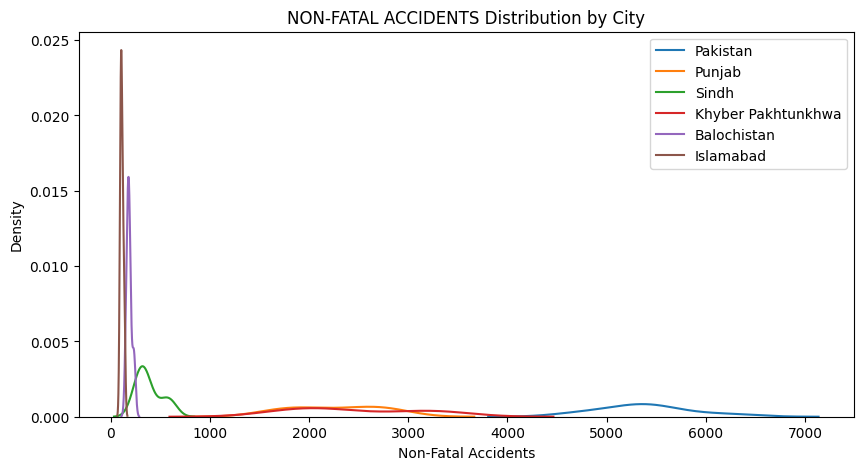

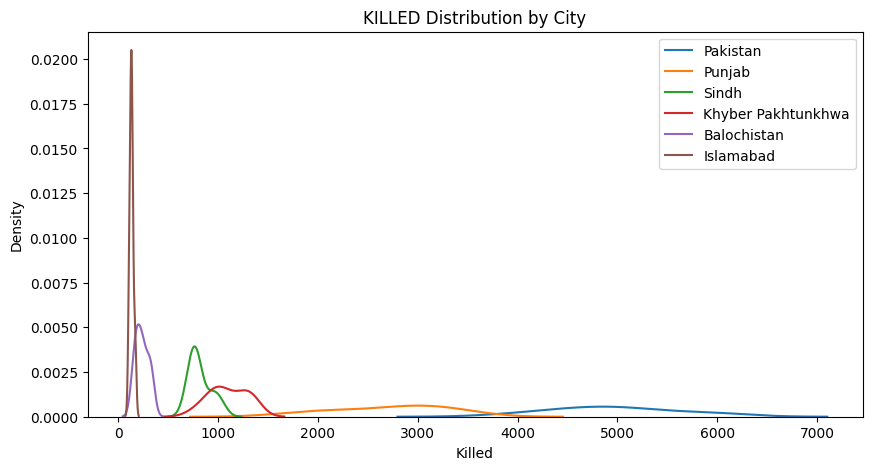

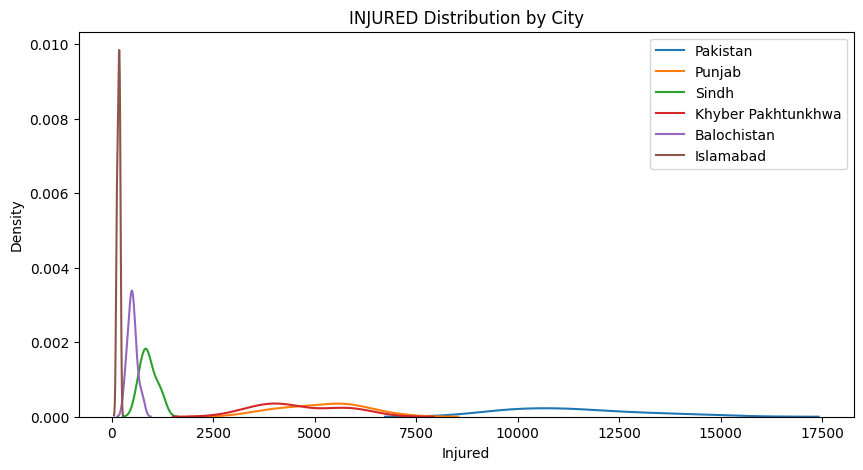

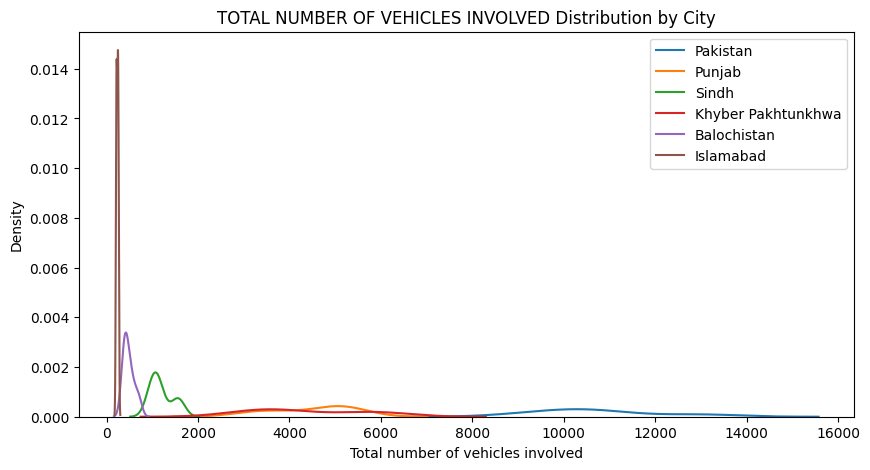

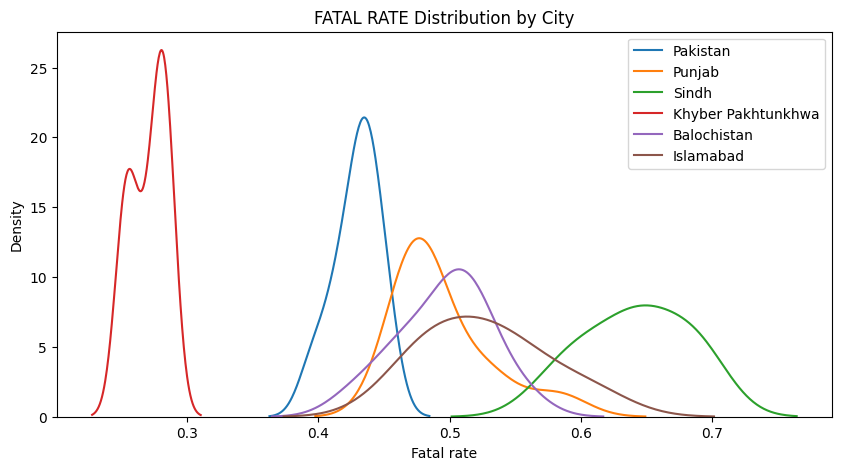

In [8]:
# KDE Plots for different features by city
features = ["Total number of accidents", "Fatal Accidents", "Non-Fatal Accidents", "Killed", "Injured", "Total number of vehicles involved", "Fatal rate"]
for feature in features:
    plt.figure(figsize=(10,5))
    for c in df.City.unique():
        sns.kdeplot(df[df["City"]==c][feature], label=c)
    plt.legend()
    plt.title(f'{feature.upper()} Distribution by City')
    plt.show()

# **Analyzing and Visualizing**

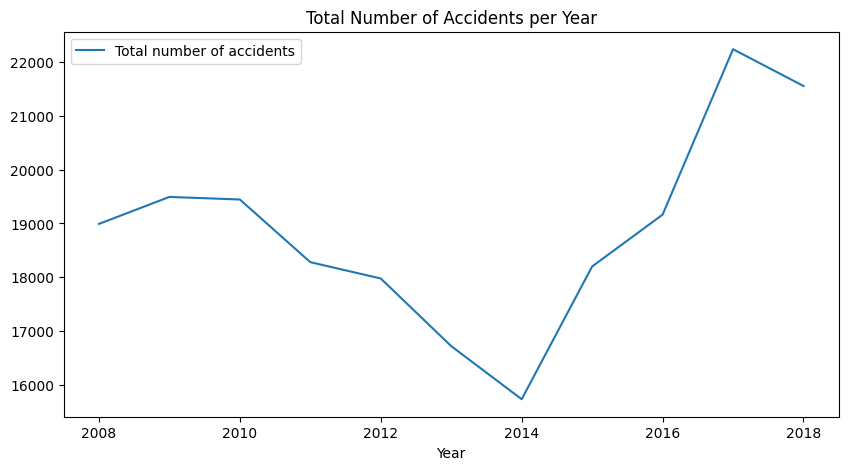

In [9]:
# Yearly trends
df.groupby("Year")["Total number of accidents"].sum().reset_index().set_index("Year").plot(figsize=(10, 5))
plt.title('Total Number of Accidents per Year')
plt.show()

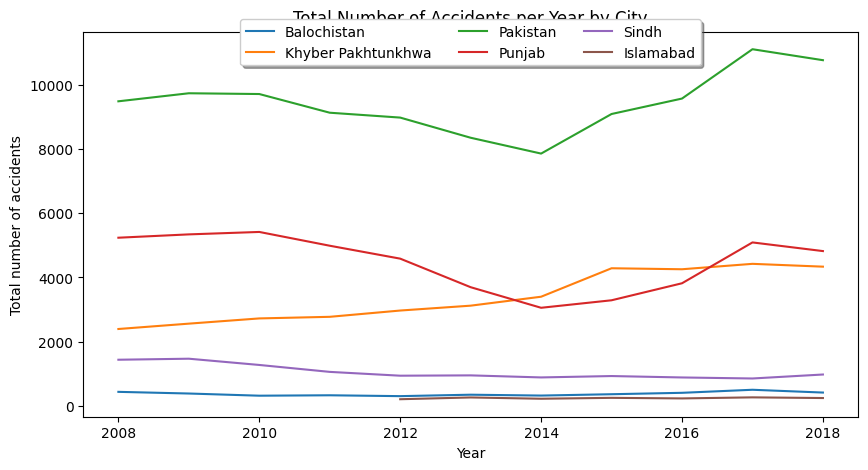

In [10]:
# Accident trends by city over the years
ax = df.groupby(["Year", "City"])["Total number of accidents"].sum().reset_index().set_index("Year")
plt.figure(figsize=(10,5))
sns.lineplot(data=ax, x="Year", y="Total number of accidents", hue="City")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=3, fancybox=True, shadow=True)
plt.title('Total Number of Accidents per Year by City')
plt.show()

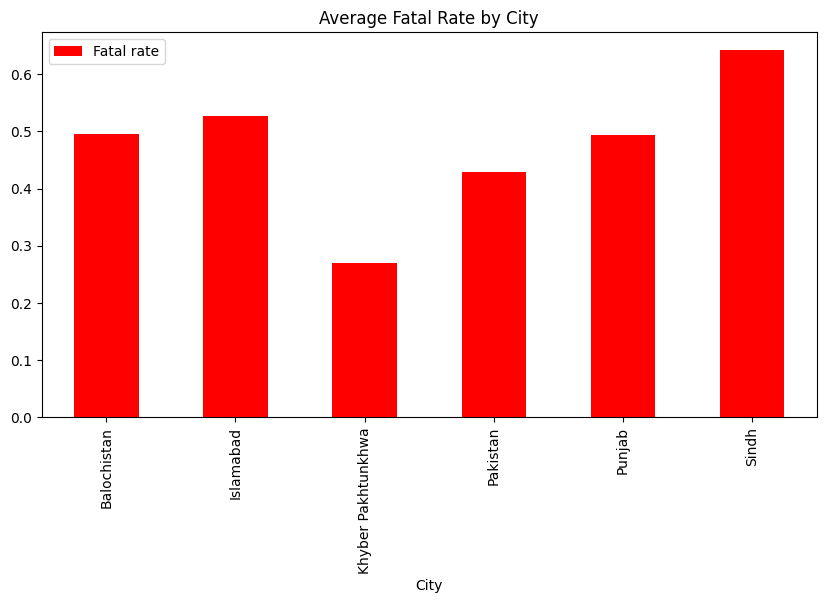

In [11]:
# Visualizing Fatal rate
df.groupby("City")["Fatal rate"].mean().reset_index().set_index("City").plot(kind='bar', figsize=(10, 5), color='red')
plt.title('Average Fatal Rate by City')
plt.show()

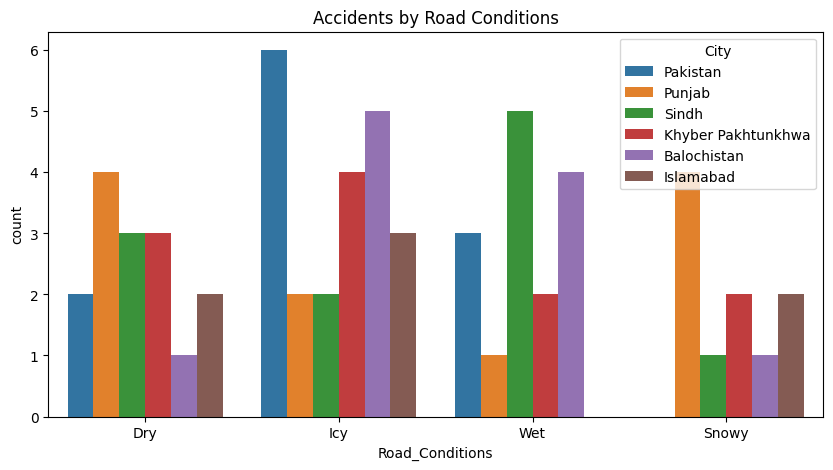

In [12]:
# Analysis of contributing factors
plt.figure(figsize=(10,5))
sns.countplot(data=df, x="Road_Conditions", hue="City")
plt.title('Accidents by Road Conditions')
plt.show()

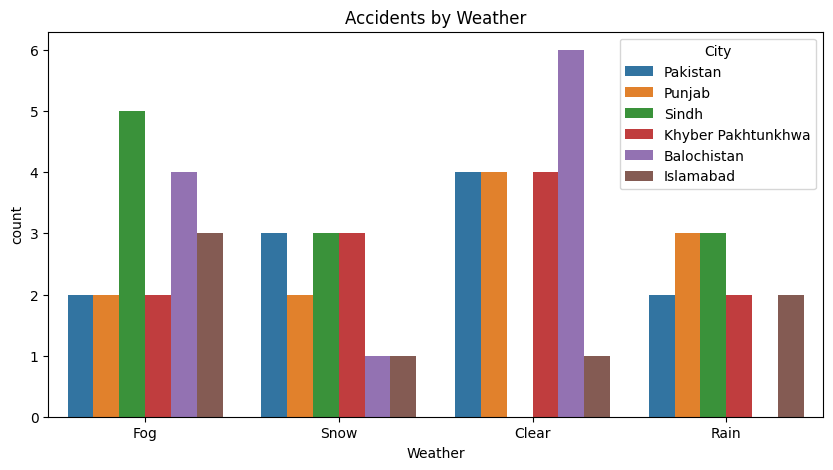

In [13]:
plt.figure(figsize=(10,5))
sns.countplot(data=df, x="Weather", hue="City")
plt.title('Accidents by Weather')
plt.show()

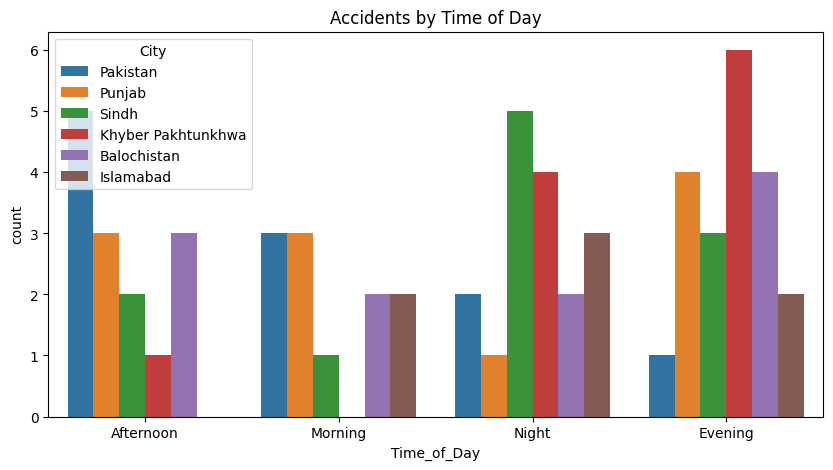

In [14]:
plt.figure(figsize=(10,5))
sns.countplot(data=df, x="Time_of_Day", hue="City")
plt.title('Accidents by Time of Day')
plt.show()